# Neural network regression

In this many-to-one regression setup, we stack the series from all inverters into a long vector and try to predict the aggregate power a few steps ahead. First we load the data and get rid of NaNs:

In [30]:
import numpy as np
import pandas as pd
from core.preprocessing import make_small_train, make_small_dev

df = pd.read_pickle('data/master_dataset.pkl').fillna(0)

dftrain = make_small_train(df, 'combined')
dfdev = make_small_dev(df)

 We define the problem and a set of hyperparemeters to tune later:

In [31]:
from core.problems import ManyToOneRegression

# Problem parameters
window = 5*12  # window size (1 hour = 12 time stamps)
future = 3*12  # prediction window into the future

problem = ManyToOneRegression(dftrain, window=window, future=future)

## Training

In [45]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, LSTM, Dropout, MaxPool1D, Flatten
from keras.regularizers import l1, l2
from keras.optimizers import Adamax, SGD
from keras.callbacks import TensorBoard, EarlyStopping

arch = 'normal' # choose between normal, conv or lstm

if arch == 'normal':
    # FULLY CONNECTED
    model = Sequential([
        Dense(100, activation='relu', input_shape=(problem.inputdim(),)),
        Dense(80, activation='relu', kernel_regularizer=l2(.1)),
        Dense(problem.outputdim(), activation='linear')
    ])
elif arch == 'conv':
    # CONVOLUTIONAL
    model = Sequential([
        Conv1D(25, kernel_size=30, input_shape=(problem.inputdim(),1)),
        Conv1D(10, kernel_size=15),
        Flatten(),
        Dense(problem.outputdim(), activation='linear')
    ])
elif arch == 'lstm':
    # RECURRENT
    model = Sequential([
        LSTM(25, activation='relu', input_shape=(problem.inputdim(),1)),
        Dense(problem.outputdim(), activation='linear')
    ])
else:
    # ERROR
    pass
    
print(model.summary())

# UNCOMMENT FOR DEBUGGING
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# display(SVG(model_to_dot(model).create(prog='dot', format='svg')))

model.compile(loss='mean_squared_error', optimizer=Adamax(), metrics=['mean_squared_error'])

tboard = TensorBoard()

# Optimization parameters
nepochs = 100

# after hours trying to debug Keras in order to use model.fit_generator(),
# I decided to just do it manually for now:
sampler = problem.sampler(batchsize=1000)
for i in range(nepochs):
    print("======== Iteration", i)
    
    X, Y = next(sampler)
    if arch == 'conv' or arch == 'lstm':
        X = np.reshape(X, (len(X),len(X[0]),1))
    
    model.fit(X, Y, batch_size=32, epochs=1, validation_split=.1, callbacks=[tboard], verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               432100    
_________________________________________________________________
dense_8 (Dense)              (None, 80)                8080      
_________________________________________________________________
dense_9 (Dense)              (None, 36)                2916      
Total params: 443,096
Trainable params: 443,096
Non-trainable params: 0
_________________________________________________________________
None
======== Iteration 0
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 0s 438us/step - loss: 8297.9572 - mean_squared_error: 8289.9251 - val_loss: 2747.0283 - val_mean_squared_error: 2739.6611
======== Iteration 1
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 0s 360us/step - loss: 3507.6000 -

======== Iteration 31
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 0s 313us/step - loss: 1065.7645 - mean_squared_error: 1059.4186 - val_loss: 982.6068 - val_mean_squared_error: 976.2572
======== Iteration 32
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 0s 311us/step - loss: 1064.0116 - mean_squared_error: 1057.6594 - val_loss: 932.6222 - val_mean_squared_error: 926.2631
======== Iteration 33
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 0s 302us/step - loss: 876.4489 - mean_squared_error: 870.0850 - val_loss: 1014.4321 - val_mean_squared_error: 1008.0680
======== Iteration 34
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 0s 301us/step - loss: 1068.0567 - mean_squared_error: 1061.6916 - val_loss: 927.6153 - val_mean_squared_error: 921.2469
======== Iteration 35
Train on 900 s

900/900 [==============================] - 0s 364us/step - loss: 813.9905 - mean_squared_error: 806.9808 - val_loss: 671.2156 - val_mean_squared_error: 664.2029
======== Iteration 66
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 0s 296us/step - loss: 819.5588 - mean_squared_error: 812.5378 - val_loss: 786.2278 - val_mean_squared_error: 779.1898
======== Iteration 67
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 0s 322us/step - loss: 848.9624 - mean_squared_error: 841.9070 - val_loss: 857.8844 - val_mean_squared_error: 850.7945
======== Iteration 68
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 0s 301us/step - loss: 765.3696 - mean_squared_error: 758.2463 - val_loss: 701.0592 - val_mean_squared_error: 693.9120
======== Iteration 69
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 0

900/900 [==============================] - 0s 312us/step - loss: 677.1810 - mean_squared_error: 669.0852 - val_loss: 628.5221 - val_mean_squared_error: 620.4036


## Prediction

/home/juliohm/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


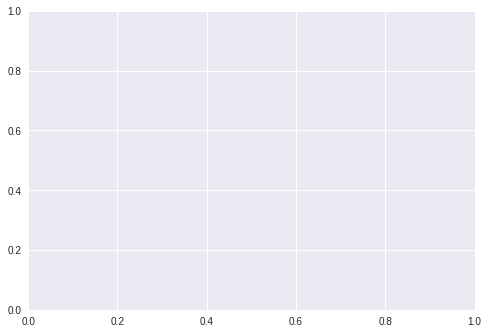

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

problem = ManyToOneRegression(dfdev, window=window, future=future)

results = []
for t in np.arange(0, len(dfdev) - window - future + 1, 12):
    x, y = problem.featurize(t)
    
    if arch == 'conv' or arch == 'lstm':
        x = np.reshape(x, (len(x), 1))
        
    yhat = model.predict(np.array([x]))
    
    results.append(pd.Series(data=yhat.flatten(), index=dfdev.iloc[t+window:t+window+future].index))

#     plt.plot(yhat.T, c="k")
#     plt.plot(y, c="b")
    
plt.legend()
plt.show()

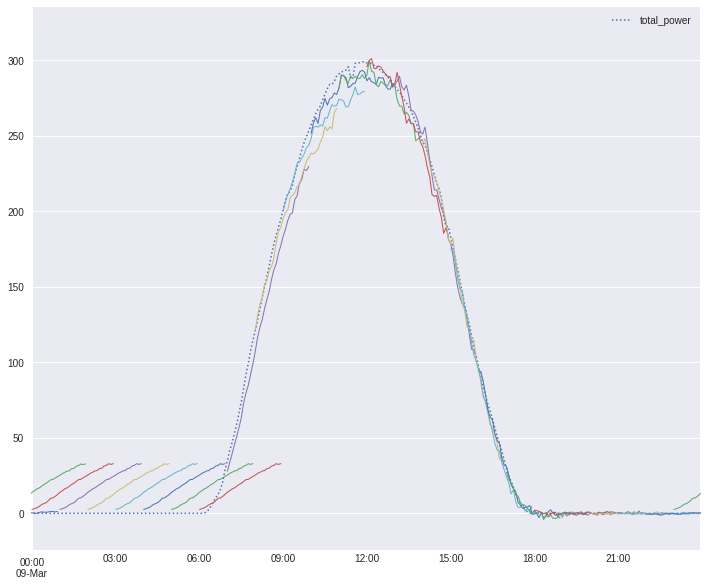

In [84]:
from core.utilities import calc_test_mse, plot_forecasts

plt.figure(figsize=(12,10))
ax = plt.gca()
plot_forecasts(dfdev, results, ax=ax)

lim = ax.get_xlim()
chunk = (lim[1] - lim[0]) / 8.
start = lim[0] + 3*chunk
end = lim[0] + 4*chunk
ax.set_xlim(start, end)

plt.show()

In [85]:
calc_test_mse(dfdev, results)

746.1613045397238